# Deep Q-Learning para _lunar lander_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---
Ejemplo basado en:
> Udacity (2019) Deep Reinforcement Learning Course. Disponible en [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn).

Comprobar si está ejecutando en Google Colaboratory.

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    %cd "drive/My Drive/ECI/eci2019-DRL/Tema 4 - Aprendizaje Profundo por Refuerzo/code/dqn/
    render = False
else:
    render = True

## Explorar entorno virtual

En este ejercicio utilizamos el entorno virtual [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) de [OpenAI](https://openai.com). 

![](https://github.com/jgromero/eci2019-DRL/blob/master/Tema%204%20-%20Aprendizaje%20Profundo%20por%20Refuerzo/code/dqn/lunarlander.gif?raw=true)

En primer lugar, vamos a explorar cómo funciona este entorno.

In [2]:
import gym

Crear entorno:

In [3]:
env = gym.make("LunarLander-v2")

Cada estado es una tupla de 8 elementos. Los dos primeros valores corresponden a la posición del módulo.

El agente puede realizar 4 acciones:

```
    NADA = 0
    ACTIVAR MOTOR DE ORIENTACION IZQUIERDO = 1
    ACTIVAR MOTOR PRINCIPAL = 2
    ACTIVAR MOTOR DE ORIENTACION DERECHO = 3
```

El objetivo en [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) es conseguir aterrizar el módulo lunar en el espacio designado ($+200$). La puntuación que se obtiene por moverse desde la parte superior de la pantalla hasta la zona de aterrizaje está en torno a $[100, 140]$. Si el módulo se desvía de la zona de aterrizaje pierde puntuación. El episodio termina si el módulo se estrella ($-100$) o se detiene ($+100$). Cada para que contacte con el suelo aumenta la puntuación ($+10$). Activar el motor principal supone una penalización ($-0.3$ por frame). 

In [4]:
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

Box(8,)
Discrete(4)
(-inf, inf)


In [5]:
print(env.observation_space)
print(env.action_space.sample())

Box(8,)
1


Implementación de un agente con comportamiento sin entrenar utilizando la clase [`Agent`](dqn_agent.py).

In [6]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

state = env.reset()
for j in range(200):
    action = agent.act(state)
    if render: env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

## Algoritmo
A continuación se proporciona una implementación genérica del algoritmo Deep Q-Learning (DQN) y su aplicación a [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/).

Se considera que el entorno [LunarLander-v2](https://gym.openai.com/envs/LunarLander-v2/) está resuelto cuando se obtienen más de $200$ puntos de media durante 100 episodios consecutivos.

In [7]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Episodio 100	Puntuacion media (100 anteriores): -147.02
Episodio 200	Puntuacion media (100 anteriores): -92.17
Episodio 300	Puntuacion media (100 anteriores): -10.85
Episodio 400	Puntuacion media (100 anteriores): 101.88
Episodio 500	Puntuacion media (100 anteriores): 136.18
Episodio 588	Puntuacion media (ultimos 100): 200.04
Problema resuelto en 488 episodios!	Puntuacion media (ultimos 100): 200.04


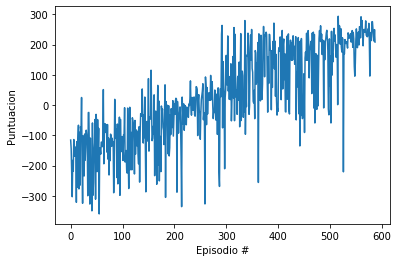

In [8]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): numero maximo de episodios de entrenamiento (n_episodios)
        max_t (int): numero maximo de pasos por episodio (n_entrenamiento)
        eps_start (float): valor inicial de epsilon
        eps_end (float): valor final de epsilon
        eps_decay (float): factor de multiplicacion (por episodio) de epsilon
    """
    scores = []                        # puntuaciones de cada episodio
    scores_window = deque(maxlen=100)  # puntuaciones de los ultimos 100 episodios
    eps = eps_start                    # inicializar epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            
            # elegir accion At con politica e-greedy
            action = agent.act(state, eps)
            
            # aplicar At y obtener Rt+1, St+1
            next_state, reward, done, _ = env.step(action)
            
            # almacenar <St, At, Rt+1, St+1>
            agent.memory.add(state, action, reward, next_state, done)
            
            # train & update
            agent.step(state, action, reward, next_state, done)
            
            # avanzar estado
            state = next_state
            score += reward
            
            if done:
                break 

        scores_window.append(score)       # guardar ultima puntuacion
        scores.append(score)              # guardar ultima puntuacion
        eps = max(eps_end, eps_decay*eps) # reducir epsilon
        
        print('\rEpisodio {}\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode, 100, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisodio {}\tPuntuacion media ({:d} anteriores): {:.2f}'.format(i_episode, 100, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nProblema resuelto en {:d} episodios!\tPuntuacion media (ultimos {:d}): {:.2f}'.format(i_episode-100, 100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # guardar pesos de agente entrenado
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Puntuacion')
plt.xlabel('Episodio #')
plt.show()

### Visualizar agente entrenado

Podemos visualizar el comportamiento del agente entrenado cargando los pesos del fichero donde se han almacenado. (Solo en entorno local, no en Google Collaboratory.)

In [9]:
# cargar pesos del fichero `checkpoint.pth`
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        if render: env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

---

### EJERCICIO

¿Podrías extender este código para otro de los entornos de OpenAI Gym? Por ejemplo, [CartPole-v0](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py).


---